## Implementation of Boosting with Frank-Wolfe Algorithms

In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
from pandas import DataFrame
from typing import Union
import matplotlib.pyplot as plt
import math
import os
from pulp import * # Optimizer
from tqdm import trange
from time import process_time
from sklearn.model_selection import KFold, train_test_split
from sklearn.datasets import load_breast_cancer

In [2]:
RANDOM_STATE = 123

#### Path to Save Figures

In [3]:
path = os.getcwd()

#### Load Dataset

In [4]:
# Import Thyroid

directory_path = './datasets'

# Get a list of all files in the directory
all_files = os.listdir(directory_path)

# Filter the list to include only CSV files
csv_files = [file for file in all_files if file.endswith('.csv')]

# Dictionary to store DataFrames
dataframes = {}

for csv_file in csv_files:
    # Construct the full path to the CSV file
    csv_file_path = os.path.join(directory_path, csv_file)

    # Read the CSV file into a DataFrame
    dataframe_name = os.path.splitext(csv_file)[0]  # Remove .csv extension from the DataFrame name
    dataframe = pd.read_csv(csv_file_path, header =0)  

    # Store the DataFrame in the dictionary with adjusted name (without .csv)
    dataframes[dataframe_name] = dataframe

In [5]:
# Split thyroid dataset into train and test
thyroid_x_train = dataframes['thyroid_x_train']
thyroid_y_train = dataframes['thyroid_t_train']
thyroid_x_test = dataframes['thyroid_x_test']
thyroid_y_test = dataframes['thyroid_t_test']

thyroid_y_train.rename(columns={'t': 'y'}, inplace=True)
thyroid_y_test.rename(columns={'t': 'y'}, inplace=True)

# remove feature_ from column names except y
thyroid_x_train.columns = [col.replace('feature_', '') for col in thyroid_x_train.columns]
thyroid_x_test.columns = [col.replace('feature_', '') for col in thyroid_x_test.columns]

# subtract 1 from column values
thyroid_x_train.columns = [int(col) - 1 for col in thyroid_x_train.columns]
thyroid_x_test.columns = [int(col) - 1 for col in thyroid_x_test.columns]

In [6]:
# Loading and prepping datasets
DATASET = 'breast_cancer'
if DATASET == 'breast_cancer':
    raw_data = load_breast_cancer()
    data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
    X = data.values
    data['y'] = raw_data.target
    y = data.y
    data.loc[y == 0, 'y'] = -1 # labels are either -1 or 1
    n_samples, n_features = X.shape

    print(f"Dataset: {DATASET}")
    print(f"Number of samples: {n_samples}")
    print(f"Number of features: {n_features}")
    print(f"Number of classes: {len(np.unique(y))}")

elif DATASET == 'thyroid':
    data_train = pd.concat([thyroid_x_train, thyroid_y_train], axis=1)
    data_test = pd.concat([thyroid_x_test, thyroid_y_test], axis=1) 
    data = pd.concat([data_train, data_test], axis=0)
    print(f"Dataset: {DATASET}")
    print(f"Number of samples: {data.shape[0]}")
    print(f"Number of features: {data.shape[1] - 1}")
    print(f"Number of classes: {len(np.unique(data['y']))}")

Dataset: breast_cancer
Number of samples: 569
Number of features: 30
Number of classes: 2


#### Visualize the dataset

#### Train-test split

In [7]:
# Split data into train and test
if DATASET == 'breast_cancer':
    y = np.array(data['y'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=RANDOM_STATE) # 80% train, 20% test

    # Full data train and test
    data_train = pd.DataFrame(X_train)
    data_train['y'] = y_train
    data_test = pd.DataFrame(X_test)
    data_test['y'] = y_test
elif DATASET == 'thyroid':
    X = data.iloc[:,:-1].values
    y = data.y



### Building DecisionTree Classifier as Base Learner

Custom Decision Tree Classifier that builds a decision tree based on the data and current distribution, creates splitting rules based on finding the features with the maximum edge (d_T A), and predicts the class of each sample in the training dataset.

In [16]:
# Building block: splitting rule, branch and leaf nodes

# Definition of Split class
class Split:
    def __init__(self, feature: int, threshold: float):

        self.feature = feature # int of the feature used to split

        self.threshold = threshold # threshold value used to split

    def split(self, data: DataFrame, sample: int):
        # Determines the split direction for a given row of data.
        num = self.feature # index of the feature
        value = data.loc[sample, num] # extract value of the feature from the sample

        # Tell classifier to go left or right based on the threshold
        if value < self.threshold:
            return "Left"
        else:
            return "Right"


# Definition of Node class
# We define two different predict methods based on the type of node: BranchNode and LeafNode.
# BranchNode: it is a node that has two children, left and right. It is used to split the data based on a rule.
# LeafNode: it is a node that does not have children. It is used to predict the label of the data.
# If the node is a leaf, the predict method returns the prediction of the node.
# Otherwise, it recursively predits on the left or right child based on the split rule.

class Node:
  def predict(self,data:DataFrame,row:int):
    # Abstract method to be implemented by BranchNode and LeafNode.
    pass


# Initializes a BranchNode object.

# rule: Split, splitting rule for the node
# left: BranchNode or LeafNode, left child node
# right: BranchNode or LeafNode, right child node
# total_weight: float, sum of the samples' weights contained in the node
# loss_as_leaf: float, error made if the node is considered a leaf

class BranchNode(Node):
  def __init__(self, rule: Split, left: Union['BranchNode', 'LeafNode'], right: Union['BranchNode', 'LeafNode'],total_weight:float,loss_as_leaf:float):
      # splitting rule
      self.rule = rule

      # left child
      self.left = left

      # right child
      self.right = right

      # total samples' weights contained in the branch node
      self.total_weight=total_weight

      # error made
      self.loss_as_leaf=loss_as_leaf

  def predict(self,data:DataFrame, row: int):
    # Predicts the label for a given row of data.
    split_result=self.rule.split(data,row)

    # Determine which child node to traverse based on the split rule
    if split_result=="Left":
      return self.left.predict(data,row)
    else:
      return self.right.predict(data,row)

class LeafNode(Node):
  def __init__(self, prediction: float,total_weight,loss):

        # label prediction
        self.prediction = prediction

        # total samples' weights contained in the leaf node
        self.total_weight = total_weight

        # error made
        self.loss = loss

  def predict(self,data:DataFrame,row:int):
    # Predicts the label for a given row of data.
    return self.prediction

In [17]:
# Generates a Decision Tree Classifier for a given distribution over examples.

class DecisionTreeClassifier():
  def __init__(self,min_samples_split=2,max_depth=None):
    # Initialise root
    self.root=None

    # Stopping conditions
    self.min_samples_split=min_samples_split
    self.max_depth=max_depth

  # Construct a full binary tree that perfectly classify the given examples.
  def build_tree(self,data,dist,curr_depth=0):

    # Recursively builds a tree

    # add column data to store the distribution
    data['d'] = dist
    
    total_weight = sum(data['d'])

    # Compute the best prediction that minimizes the training error on this node.
    pred,loss = self.compute_loss(data)
    m, _ = data.shape
    # if loss is minimum or other stopping conditions are met, construct a leaf node
    if loss==0.0 or m<self.min_samples_split or (self.max_depth is not None and curr_depth > self.max_depth-1):
      return LeafNode(pred,total_weight,loss)
    
    # Find the best splitting rule that maximizes the edge
    feature_index, best_threshold=self.find_best_split_edge(data)
    # initialize Split class with given feature and threshold
    rule = Split(feature_index,best_threshold)

    # Split the train data for left/right children
    # if val < threshold, go left, else go right
    lindices = []
    rindices = []
    for i in data.index:
      split = rule.split(data, i)
      if split == "Left":
        lindices.append(i)
      elif split == "Right":
        rindices.append(i)
      else:
        raise ValueError("Invalid split value")
    
    # If the split has no meaning, construct a leaf node.
    if lindices==[] or rindices==[]:
      pred,loss = self.compute_loss(data)
      return LeafNode(pred,total_weight,loss)
    
    # Grow the tree 
    ltree = None # left child
    rtree = None # right child
    columns_to_select = data.columns.tolist()[:-1] # Exclude the 'd' column, keep the 'y' column
    data_left = data.loc[lindices,columns_to_select] 
    data_right = data.loc[rindices,columns_to_select]
    dist_left = data.loc[lindices,'d'] # distribution of the left child
    dist_right = data.loc[rindices,'d'] # distribution of the right child

    if self.max_depth == 1:
      # the children from this node must be leaves
      # add the distribution back to the data 
      data_left['d']= dist_left 
      data_right['d']= dist_right 
      # create the leaves for each subset of data
      ltree = self.construct_leaf(data_left)
      rtree = self.construct_leaf(data_right)
    else:
      # the children from this node might be branches.
      # recursively build the tree
      ltree = self.build_tree(data_left,dist_left, curr_depth+1)
      rtree = self.build_tree(data_right, dist_right, curr_depth+1)
    # if ltree and rtree are leaves, branch node is actually a leaf
    # return branch nodes if children are not leaves
    return BranchNode(rule, ltree, rtree, total_weight, loss)


  def construct_leaf(self,data):
    # Compute the best prediction that minimizes the training error on this node.
    (pred, loss) = self.compute_loss(data)
    total_weight = sum(data['d'])
    return LeafNode(pred, total_weight, loss)

  # Method to find the class with the biggest sum of samples' weights in a node and the corresponding loss. 
  # It returns the best prediction that minimizes the error on the node. max_class is the prediction
  # label that minimizes the training loss. node_error is the training loss when the prediction is max_class.
  

  def compute_loss(self,data):
    counter = {-1:0,1:0} # dictionary to store sum of samples' weights of each class
    m = data.shape[0] # number of samples
    d = data['d'].values # distribution of the samples
    y = data['y'].values # target values

    for i in range(m):
      key = y[i] # target value of the i-th sample
      counter[key] += d[i] # increment the sum of samples' weights of the class

    total= sum(counter.values()) # total sum of samples' weights in the node

    # Find the class with the largest total sum of samples' weights
    max_class = max(counter,key=counter.get)
    w = counter[max_class] # total weight of the "most weighted" class
    if total > 0.0:
      # computes the proportion of the total weight that is not accounted for by the most weighted class (i.e., the impurity of the node).
      node_error= total * (1.0 - (w/total)) 
    else:
      node_error=0.0
    return max_class, node_error


 
  # Method to find split that maximizes the edge, comparing the splits for all the features 
  # and for all possible thresholds. Here, edge is the weighted accuracy.  Given a distribution `dist[..]` over the training examples,
  # the edge is `\sum_{i} dist[i] y[i] h(x[i])` where `(x[i], y[i])` is the `i`th training example.

  # The subtraction of 2.0 * trio[1] * trio[2] in the edge calculation penalizes instances 
  # where the predicted class (+1) does matches the actual class (+1). While, we are increasing the edge for misclassified examples.
  # This penalty encourages the algorithm to find thresholds that better separate the classes (+1 and -1).

  # Find a split that maximizes the edge
  def find_best_split_edge(self,data):

    m,n = data.shape # number of samples and features
    d = data['d'].values # distribution of the samples
    y = data['y'].values # target values

    edges =[] # list to store the edge values for each feature
    threshold_list=[] # List to store the best threshold for each feature

    for col in range(n-2): # exclude the last two columns, which contain the target and the distribution
      col_values = data.iloc[:,col].values

      # for each example, store feature value, the distribution and the target value
      triplets = [[col_values[i], d[i], y[i]] for i in range(m)]

      # sort the triplets by feature value
      triplets.sort(key=lambda x: x[0])

      # Initial threshold: smallest value of the feature -1
      best_threshold = triplets[0][0] - 1.0

      # Compute the edge of the hypothesis that predicts `+1` for all instances.
      # it would subtract d*y if y = -1
      edge = sum(d * y for _, d, y in triplets)
      best_edge = abs(edge)

      for i, trio in enumerate(triplets):
          # feature value
          left = trio[0]

          # Adjust edge by subtracting the penalty for misclassifying instances (we are increasing the edge 
          # for miscalssified instances and doing the opposite for the ones that are classified correctly)
          # to change the class of the point from +1 to -1, we subtract 2*d*y
          edge -= 2.0 * trio[1] * trio[2]

          try:
            # move to the next example
            next = triplets[i+1]
          except:
            # if there is no next example, the biggest threshold considered is the left-most point + 1
            right = left + 1.0

          # if i is not the last example, the right-most point is the next example's feature value
          if i != m-1:
            # feature value of the next example
            right = next[0]

          #possible thresholds are all the mean values between the left and right points
          threshold = (left + right) / 2.0


          if abs(edge) > best_edge:
              best_edge = abs(edge)
              best_threshold = threshold

      edges.append(best_edge)
      threshold_list.append(best_threshold)
    
    # Find the feature with the maximum edge
    feature_index = edges.index(max(edges))
    best_threshold= threshold_list[feature_index]
    
    return feature_index, best_threshold


  #Build the tree and return the root node
  def fit(self,data,dist):
    self.root = self.build_tree(data,dist) # topmost node of the tree
    return self.root 
  
  # If the root is a BranchNode: The tree will use a rule (based on one of the features of your data) to decide whether to go left or right.
  # If the root is a LeafNode: The tree will predict the label of the data.


## Boosting Algorithms

#### Set Constant Parameters

In [18]:
TOLERANCE = 0.01
SUB_TOLERANCE = 1e-9
HALF_TOLERANCE = 0.5 * TOLERANCE

#### LPBoost

##### Linear Programming Problem for LPBoost

Minimize the margin 
\begin{aligned}
\beta\  
\end{aligned}

Subject to:

\begin{aligned}
& \mathbf{d} \cdot \mathbf{u}^m \leq \beta, \quad \text{for } 1 \leq m \leq t \\
& \mathbf{d} \in \mathcal{P}^N \\
& \mathbf{d} \leq \frac{1}{\nu} \mathbf{1}
\end{aligned}


1. For each weak classifier, the constraint ensures that the weighted combination of the responses of the weak classifiers, where d corresponds to sample weights and u, which corresponds to a N-dimensional vector that combines a base hypothesis h_t with the labels y_n of the N examples, does not exceed the margin 𝛽 for each weak classifier m up to the t-th final classifier
2. d must be a valid probability distribution, meaning that the elements of d are non-negative and sum to 1.
3. elements of d must not exceed the upper bound set by 1/v




In [19]:
# Define LPModel

class LPModel:
  def __init__(self, size, ub):
    # Initialize the linear programming problem with a minimization objective
    self.model = LpProblem("LPProblem",LpMinimize)
    self.size = size

    # Define the variable beta (the objective to be minimized)
    self.beta = LpVariable(name="beta")
    # Add the objective function to the model to minimize beta
    self.model += self.beta, "Objective"  #objective function

    # Define the sample weights with bounds between 0 and ub
    self.dist = [LpVariable(name= "d[{}]".format(i),lowBound=0.0,upBound=ub) for i in range(self.size)] #sample weights
    
    # Add the constraint that the sum of sample weights is 1
    constr1 = LpConstraint(sum(self.dist), sense=LpConstraintEQ, rhs=1.0)
    self.model.addConstraint(constr1)
    self.constrs=[constr1]

  def update(self,data:DataFrame,target,clf):
    # Calculate the predictions for each sample given one classifier
    u = [y * clf.predict(data, i) for i, y in enumerate(target)]

    # Create the edge constraint for the current classifier
    edge_constr = lpSum(d * yh for d, yh in zip(self.dist, u)) <= self.beta
    self.model += edge_constr
    self.constrs.append(edge_constr)

    # Solve the linear programming problem with the pulp solver
    self.model.solve(PULP_CBC_CMD(msg=False))

    # Check if the solution is optimal
    status = LpStatus[self.model.status]
    if status!='Optimal':
      raise Exception
    
    # Return the optimal value of beta
    optimal_beta = self.beta.varValue
    return optimal_beta

  def distribution(self):
    # Return the current values of the sample weights
    return [var.varValue for var in self.dist]

  # Accessing Lagrangian multipliers
  def weight(self):
    # Return the absolute values of the Lagrangian multipliers for the edge constraints
    return [abs(constr.pi) for constr in self.constrs[1:]]

The goal of LPBoost is to solve the following edge minimization problem: 

$$
\min _{\boldsymbol{d}} \max _{\boldsymbol{j} \in [n]}(d^{T}A)_j + f(d)
$$

where f(d) is a barrier function that causes the function to explode, i.e. go to infinity if the distribution is outside the probability simplex. 

By Fenchel duality
$$
\max _{\boldsymbol{w} \in \mathcal{P}^n}-f^{\star}(-A \boldsymbol{w}) = \max _{\boldsymbol{w} \in \mathcal{P}^n}\min _{\boldsymbol{d} \in \mathcal{P}_\nu^m}\boldsymbol{d}^{\top} A \boldsymbol{w}
$$

When we want to compute the objective function to maximize $-f^{\star}(-A\boldsymbol{w})$ we know that

$$f^{\star}(-A \boldsymbol{w})=\max _{\boldsymbol{d}}\left[-\boldsymbol{d}^{\top} A \boldsymbol{w}-f(\boldsymbol{d})\right]=\max _{\boldsymbol{d} \in \mathcal{P}_\nu^m}-\boldsymbol{d}^{\top} A \boldsymbol{w}= - \min _{\boldsymbol{d} \in \mathcal{P}_\nu^m}\boldsymbol{d}^{\top} A \boldsymbol{w}$$

Thus, the objective function can be computed by minimizing the inner product between $d^T$ and $Aw$, or the weighted margin.

After choosing the hypothesis with the highest edge, the distribution should be updated so that the weights of mis-classified examples increase, leading to a decrease in the edge of previous hypothesis 

The general idea of boosting is this: Given a distribution over training examples, the base learner produces a hypothesis with an edge, defined as an affine transformation of the weighted training error, that is slightly better than random guessing. Assuming the base learner maximizes the edge for a given distribution, which is a stronger assumption, it results in a significantly more robust combined hypothesis.



In [20]:
# Define LPBoost algorithm Class

class LPBoost:
  def __init__(self, data, nu):
    size = data.shape[0]
    uni = 1.0/size
    self.dist = [uni for _ in range(size)] # initialize uniform distribution over samples
    self.beta_hat = 1.0
    self.eps = uni # tolerance parameter for the stopping condition
    self.size = size
    self.nu = nu # capping param (v) 
    self.lp_model = None

  # Ensure that nu is within the valid range [1, number of training examples]
  def set_nu(self, nu):
    assert 1.0 <= nu <= self.size # must be in [1, # of training examples]
    self.nu = nu

  def set_tolerance(self, tolerance):
    self.eps = tolerance

  # Initialize the LP solver with upper bound
  def init_solver(self):
    ub= 1.0/self.nu
    assert 0 <= ub <= 1.0 # upper bound must be in [0,1]

    self.lp_model = LPModel(self.size, ub)

  # Update sample distribution and return optimal beta
  def update_distribution(self,data,target,h:Node):
    if self.lp_model is not None:
      return self.lp_model.update(data,target,h)
    else:
      raise ValueError("Lpmodel not initialised")

  def LPboost(self, data_train,data_test,target,eps):

    self.set_tolerance(eps)
    self.init_solver() # Initialize LP solver
    classifiers=[]
    weights=[]
    max_iter= 100

    # Items to track for results
    times=[]
    test_error =[] 
    objective=[]   
    self.terminated = float('inf') 

    start = process_time()

    for t in trange(max_iter):
      # Train a new base learner that is very shallow
      base_learner = DecisionTreeClassifier(max_depth=1)
      h = base_learner.fit(data_train,self.dist)

      # Compute current edge of the learner: d_T*A for given hypothesis h
      bhat = sum(y* h.predict(data_train,i)* d for i,(y,d) in enumerate(zip(target,self.dist)))
      self.beta_hat = min(bhat, self.beta_hat) # Update beta_hat to be the minimum edge
      # Solve the linear program using the LP solver
      beta_star=self.update_distribution(data_train,target,h)

      classifiers.append(h)

      # Stopping condition: terminate if optimal value of LP is greater than or equal to beta_hat - eps
      if beta_star >= self.beta_hat - self.eps:
        print(f"Break loop at: {t}")
        self.terminated= len(classifiers)
        break

      # Update the samples' distribution
      self.dist = self.lp_model.distribution()

      # Calculate time elapsed
      times.append(process_time() - start)

      # Calculate the objective function value
      weights = self.lp_model.weight()
      objective.append(self.lp_objval(data_train, target, weights, classifiers, self.nu))
      test_error.append(self.loss(data_test,classifiers,weights))

    # save the classifiers and their weights for lb_objval
    clfs_weights = [(w,clf) for w,clf in zip(weights,classifiers) if w!=0]
    
    return clfs_weights, times, test_error, objective

  # Calculate the proportion of misclassified points
  def loss(self,data,clfs,wts):
    y = data['y']
    error=0.0
    size = data.shape[0]
    for i in range(size):
        pred = self.final_pred(i,data,clfs,wts)
        # Increment error if the prediction sign differs from the actual target value
        if pred*y[i]<=0.0:
          error +=1.0
    return error/size

  # Calculate the final prediction for a single instance: weighted sum of base classifiers' predictions
  def final_pred(self,i, data, classifiers, weights):
    return sum(w * h.predict(data, i) for h, w in zip(classifiers, weights))

  #Compute the objective function value: -f*(-Aw) = min(d^T*A*w)
  def lp_objval(self,data, target, weights, classifiers, nu):
      m = data.shape[0]

      # margins = A*w
      margins = [y * self.final_pred(i, data, classifiers, weights) for i, y in enumerate(target)]

      #extract the indices in ascending order for the margin
      indices = np.argsort(margins)

      # We create a distribution that assigns greater weights to the most poorly classified examples, 
      # aiming to minimize the objective function d^T * A * w, which is equivalent to -f * (-A * w) = min(d^T * A * w).
      # Specifically, the example with the worst classification (smallest margin) receives the highest weight (max_weight),
      # while progressively smaller weights are assigned to examples with better classifications based on their sorted positions (ascending margins).

      total = 1.0
      max_weight = 1.0 / nu
      dist = [0.0] * m

      for i in indices:
          if max_weight <= total:
              dist[i] = max_weight
              total -= max_weight
          else:
              dist[i] = total
              break

      # Sanity checks: ensure all distribution values are within [0, 1] and sum to 1
      assert all(0.0 <= d <= 1.0 for d in dist) 
      assert abs(1.0 - np.sum(dist)) < 1e-6 #

      # Calculate the objective function value using margins and updated distribution:
      #The objective function is: d^T*A*w 
      objval = np.sum(dist * np.array(margins))
      
      return objval


#### KFold Cross Validation for capping hyperparameter

In [ ]:
# KFold setup
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Extracting features and labels
data_train.reset_index(drop=True, inplace=True)
X = data_train.iloc[:, :-1].values
y = data_train['y']

size = X.shape[0] / 5
CAP_RATIOS = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

errors_split = []
v_errors = {}

for v in CAP_RATIOS:
    print("---------------------------")
    print(f"Starting with v = {v}")
    for train_index, test_index in kfold.split(X, y):
        train_index = np.array(train_index, dtype=int)
        test_index = np.array(test_index, dtype=int)
        x_train_fold, x_test_fold, y_train_fold, y_test_fold = X[train_index], X[test_index], y[train_index], y[test_index]
        
        data = pd.DataFrame(x_train_fold)
        data['y'] = y_train_fold.reset_index(drop=True)

        data_t = pd.DataFrame(x_test_fold)
        data_t['y'] = y_test_fold.reset_index(drop=True)

        LP_boost = LPBoost(data, nu = v * size)
        clfs_weights, times, test_error, objective= LP_boost.LPboost(data, data_t, y_train_fold, eps=0.01)
        errors_split.append(test_error[-1])
    v_errors[v]=np.mean(errors_split) # average error for each v
best_v = min(v_errors, key=v_errors.get) # v with the lowest average error
print("The best v value for this dataset is: ", best_v)
print("The lowest average error for the best v is: ", v_errors[best_v])


In [13]:
# Average Computing Time over capping parameters
CAP_RATIOS = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
comp_times=[]
for v in CAP_RATIOS:
    print("---------------------------")
    print(f"Starting with v = {v}")   
    LP_boost = LPBoost(data_train, nu = v * data_train.shape[0])
    clfs_weights, times_lp, test_error_lp, objective_lp= LP_boost.LPboost(data_train, data_test, data_train['y'], eps=0.01)
    comp_times.append(times_lp[-1])
avg_times=np.mean(comp_times) # average comp time for each v

print(f'Average Computation time over the capping params: {avg_times}')

---------------------------
Starting with v = 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [00:02<00:10,  7.63it/s]


Break loop at: 17
---------------------------
Starting with v = 0.2


 19%|█▉        | 19/100 [00:01<00:07, 11.11it/s]


Break loop at: 19
---------------------------
Starting with v = 0.3


 13%|█▎        | 13/100 [00:00<00:06, 14.47it/s]


Break loop at: 13
---------------------------
Starting with v = 0.4


 10%|█         | 10/100 [00:00<00:08, 10.07it/s]


Break loop at: 10
---------------------------
Starting with v = 0.5


  2%|▏         | 2/100 [00:00<00:07, 12.82it/s]

Break loop at: 2
Average Computation time over the capping params: 0.575


In [21]:
# Run final LPBoost model using the best v
if DATASET == 'breast_cancer':
    best_v = 0.1
elif DATASET == 'thyroid':
    best_v = 0.2

LP_boost = LPBoost(data_train, nu = best_v * data_train.shape[0])
clfs_weights, times_lp, test_error_lp, objective_lp= LP_boost.LPboost(data_train, data_test, data_train['y'], eps=0.01)

 59%|█████▉    | 59/100 [00:21<00:14,  2.76it/s]

Break loop at: 59


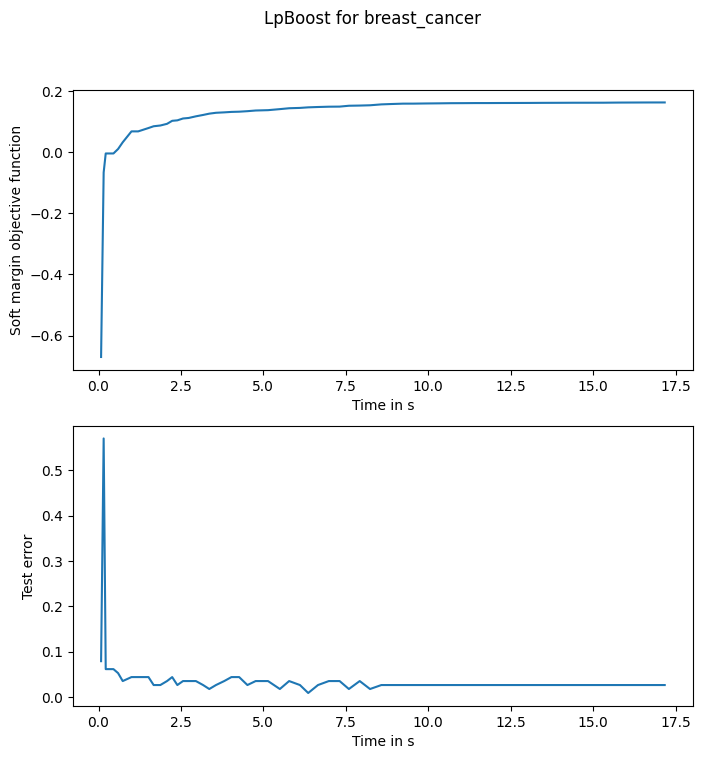

In [22]:
# Plot the objective function and test error against log time s
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(times_lp,objective_lp)
axs[1].plot(times_lp,test_error_lp)

axs[0].set_xlabel('Time in s')
axs[0].set_ylabel('Soft margin objective function')
 
axs[1].set_xlabel('Time in s')
axs[1].set_ylabel('Test error')

fig.suptitle(f'LpBoost for {DATASET}')
plt.show()

# save figure
#fig.savefig(path + f'/plots/LpBoost_{best_v}_{DATASET}.png')

# Modified LPBoost 

In [24]:
# Define Modified LP Boost Model

class MLPB_Model:
  def __init__(self, size, ub):
    # Initialize the linear programming problem with a minimization objective
    self.model = LpProblem("LPProblem",LpMinimize)
    self.size = size

    # Define the variable beta (the objective to be minimized)
    self.beta = LpVariable(name="beta")
    self.model += self.beta, "Objective"  #objective function

    # Define the sample weights with bounds between 0 and ub
    self.dist = [LpVariable(name= "d[{}]".format(i),lowBound=0.0,upBound=ub) for i in range(self.size)] #sample weights
    
    # Add the constraint that the sum of sample weights is 1
    constr1 = LpConstraint(sum(self.dist), sense=LpConstraintEQ, rhs=1.0)
    self.model.addConstraint(constr1)
    self.constrs=[constr1]

  def update(self,data:DataFrame,target,clf):
    
    # accuracy of hypothesis 
    u = [y * clf.predict(data, i) for i, y in enumerate(target)]

    # Create the edge constraint for the current classifier
    edge_constr = lpSum(d * yh for d, yh in zip(self.dist, u)) <= self.beta
    self.model += edge_constr
    self.constrs.append(edge_constr)

    # Solve the linear programming problem with the pulp solver
    self.model.solve(PULP_CBC_CMD(msg=False))

    # Check if the solution is optimal
    status = LpStatus[self.model.status]
    if status!='Optimal':
      raise Exception
    # returns lagrangian multipliers
    return [abs(constr.pi) for constr in self.constrs[1:]]


#### Modified LPBoost algorithm

A new boosting algorithm inspired by the LPBoost and Frank-Wolfe (FW) framework is introduced. The MLPBoost algorithm combines two update mechanisms for the weak-learner weights' w: a primary FW update (denoted as F) which uses either a pairwise or shortstep update rule, and a secondary LP update. The algorithm determines the most suitable weight vector for the update by assessing which weight vector optimally minimizes the objective function $\tilde{f}^*(-A \bm{w}_t)$

#### Sorting-based algorithm for defining the distribution

<img src="distribution.png" alt="Distribution Image" width="600">

We are taking the initial distribution  $\bm{d} _ {0,i} \propto e^{ \frac{(-A w_t)_i}{\beta} }$.
In our code, we opt to calculate log(Z) instead of Z and utilize the log-sum-exp trick since Z is the sum over exponential values. If the exponent is too big or too small, Z can overflow or underflow respectively.
\begin{equation*}
\log\sum_{i=1}^{n} e^{x_i}=\log(e^{x_{max}})+\log\sum_{i=1}^{n} e^{x_i-x_{max}}=x_{max}+ \log(\sum_{i=1}^{n} e^{x_i-x_{max}})
\end{equation*}

Expanding on that notion in our code, we define the variables *small* and *large* and iteratively compute $\log \left(e^{small}+e^{large}\right)=$ $large+\log \left(1+e^{small-large}\right)$ to optain logZ. This ensures that the addition of the exponential values is done in a numerically stable way, preventing overflow.

Therefore, we compute the logarithmic values of the initial distribution and Z so that $\log\phi= \log(1-\mu (i-1)) - \log(Z)$.


#### Frank-Wolfe Update Rules

$\boldsymbol{w}_{t+1}^{(1)}=\boldsymbol{w}_t+\lambda_t\left(\boldsymbol{e}_{j_{t+1}}-\boldsymbol{w}_t\right)$ where $\boldsymbol{e}_{j_{t+1}}$ correspond to the a vector that contains as many zeros as the number of base learners, but the $j+1$ position that is equal to 1

#### Classic Frank-Wolfe
$\lambda_t=\frac{2}{t+2}$.

#### Short-step strategy
 $\lambda_t =
 \operatorname{clip}_{[0,1]} \frac{\boldsymbol{d}_t^{\top} A\left(\boldsymbol{e}_{j+1}-\boldsymbol{w}_t\right)}{\eta\left\|A\left(\boldsymbol{e}_{j+1}-\boldsymbol{w}_t\right)\right\|_{\infty}^2}$

#### Pairwise strategy
This approach navigates the weight space by leveraging the difference between the forward direction vector $ \bm{e}_{t+1} $ and the away direction vector $ \bm{e}_{\text{Away}} $ (corresponding to the hypothesis having the smallest edge amongst the first t hypotheses), added to the current weight vector $ \bm{w}_t $, to determine the update direction.\
After computing the away basis, a line search method is implemented to find the best lambda or step size that minimizes the objective function, where the max lambda corresponds to the weight of the classifier determined in the away method: 

$\lambda_t \leftarrow \arg \min_{\lambda \in [0, \lambda_{t,\text{max}}]} \tilde{f}^*(-A(\bm{w}_t + \lambda(\bm{e_{j_{t+1}}} - \bm{e}_{\text{Away}})) $
 #### Stopping Condition of MLPBoost

 Optimality gap:  $\epsilon_t:=\min _{0 \leq \tau \leq t}\left(\boldsymbol{d}_\tau^{\top} A\right)_{j_{\tau+1}}+\tilde{f}^{\star}\left(-A \boldsymbol{w}_t\right)$

If $\eta=2 \ln (m / \nu) / \epsilon$,

then $\epsilon_t \leq \epsilon / 2$ implies $-f^{\star}\left(-A w_t\right) \geq g-\epsilon$.\
Note: we will use $\beta$ to refer to g in the code below.

In [25]:
# Define MLPBoost algorithm with Frank-Wolfe strategies
class MLPBoost:
    def __init__(self, data, nu):
        size = data.shape[0]
        assert size != 0

        half_tolerance = HALF_TOLERANCE 
        self.nu = nu
        eta = math.log(size/nu) / half_tolerance # regularised parameter

        self.max_iter=100
        self.eta = eta
        self.size = size
        self.half_tolerance = half_tolerance
        self.nu = nu
        self.lp_model = None
        self.weights = []
        self.beta = 1.0
        self.sub_tolerance = SUB_TOLERANCE

    # we are making sure that nu is between 1 and m (number of training examples)
    def set_nu(self, nu):
        assert 1.0 <= nu <= float(self.size)# must be in [1, # of training examples]
        self.nu = nu
       

    def init_solver(self):
        upper_bound = 1.0 / self.nu
        assert 0.0 <= upper_bound <= 1.0 # upper bound must be in [0,1]
        self.lp_model = MLPB_Model(self.size, upper_bound)

    #number of LPBoost calls
    def get_lpb_call(self):
        return self.lpb_call

    # Computing the objective function value: -f_tilde*(-Aw) = d^T*A*w + 1/eta * entropy
    def objval(self, data: pd.DataFrame, target: pd.Series, classifiers, weights):
        # log distribution projected to capped simplex
        dist = self.w_samples(data, target, classifiers, weights)

        # d^T*A*w
        weighted_margin = self.weighted_marg(data, target, dist, classifiers, weights) 

        # delta(d)
        entropy = sum(d * math.log(d) if d != 0.0 else 0.0 for d in dist) + math.log(self.size)

        return weighted_margin + (entropy/self.eta)

    # calculates weighted predictions over classifiers for a sample i: w*h
    def final_pred(self, i: int, data: pd.DataFrame, classifiers, weights):
        result = sum(w * h.predict(data, i) for h, w in zip(classifiers, weights))
        return result
    
    #to calculate the updated distribution 
    def w_samples(self, data: pd.DataFrame, target: pd.Series, classifiers, weights):
        dist = self.log_dist(data, target, classifiers, weights)
        return self.projection_to_capped_simplex(dist)
    
    # d^T*A*w: weighted margins
    def weighted_marg(self, data: pd.DataFrame, target: pd.Series, dist, classifiers, weights):
        return sum(d * float(y) * self.final_pred(i, data, classifiers, weights) for i, (d, y) in enumerate(zip(dist, target)))

    # Compute the log of the initial distribution d: log_d= -eta * (Aw)_i (in paper 1/beta is used as notation)
    def log_dist(self, data: pd.DataFrame, target: pd.Series, classifiers, weights):
        log_d = np.array([-self.eta * y * self.final_pred(i, data, classifiers, weights) for i, y in target.items()])
        return log_d

    def projection_to_capped_simplex(self, dist):
        size = len(dist)

        # Sort indices of the initial distribution in non-increasing order
        index_x = list(range(size))
        index_x.sort(key=lambda i: dist[i], reverse=True)

        dist = list(dist)

        logZ = [] # this contains the logsums relative to the samples  
        # we are doing a list of logZ because we don't know which index is "i" yet so we are treating every index 
        # as a potential "i" but in the reversed  way! since Z takes from r=i till m
        # Note: we do this bcz we are updating dist in real time so we need to define all possible logsum before we start editing dist

        prev_logsum = None
        #This procedure computes ln(e^d_i + e^d_j) = d_j  + ln(1 + e^(d_i-d_j))
        for i in reversed(index_x):
            if prev_logsum is not None:
                small = min(prev_logsum, dist[i])
                large = max(prev_logsum, dist[i])
                logsum = large + math.log(1.0 + math.exp(small - large)) # to avoid overflow in the exponential
            else:
                logsum = dist[i]
            logZ.append(logsum)
            prev_logsum = logsum

        # Reversing the logsums to have it in original order
        logZ = logZ[::-1]

        # Set up constants for later use
        ub = 1.0 / self.nu # ub is the upper bound defined in our report as mu
        log_cap = math.log(self.nu) #for convenience we are defining log_cap= -log(ub) = -log(1/nu) = -log(1) + log(nu) = log(nu)

        # Define a list of tuples containing: index i of sorted decreasing d_0 and the corresponding logsum which is the sum of dist starting from the index i 
        ix_with_logZ = list(enumerate(zip(index_x, logZ)))

        for i, (i_sorted, logsum) in ix_with_logZ:
            log_phi = np.log(1.0 - ub * i) - logsum ##log_phi= log((1 - ub * i) / Z))
            current_d = dist[i_sorted]

            #breaking condition: if it is satisfied, we know that current i_sorted is our "i", and we fix log_phi
            if log_phi + current_d + log_cap <= 0.0: #log_phi + log d_0,i <= log(ub)
                #building the distribution d_t,r = phi*d_0,r for all the weights starting from r=i,...,m
                dist[i_sorted] = math.exp(log_phi + current_d) #we are applying the exponential to the log forms in order to get d
                for _, (ii, _) in ix_with_logZ[i+1:]: #we us the same logZ from now on
                    dist[ii] = math.exp(log_phi + dist[ii]) #do the same for the rest of the indexes
                break

            #all the previous components of the distribution vector are equal to the maximum possible
            #weight 1/nu
            dist[i_sorted] = ub

        return dist                 
    
    #loss method returns the proportion of the missclassified points
    def loss(self,data,clfs,wts):
      y = data['y']
      error=0.0
      size = data.shape[0]
      for i in range(size):
          pred = self.final_pred(i,data,clfs,wts)
          # if sign of the prediction is different from the target value, increment the error by 1
          if pred*y[i]<=0.0:
            error +=1.0
      return error/size


    #LPBoost Weight Update
    def lpb_weight(self, data: pd.DataFrame, target: pd.Series, opt_h):
        lp_model = self.lp_model
        if lp_model is None:
            raise ValueError("LP model is not initialized")

        return lp_model.update(data, target, opt_h)

    # Update sample weights depending on the strategy
    def fw_weight(self, data: pd.DataFrame, target: pd.Series, dist, position: int, classifiers, weights, edge_of_h: float, iteration: int, strategy):
        if strategy == "Pairwise":
            return self.pairwise_weight(data, target, dist, position, classifiers, weights)
        elif strategy == "ShortStep":
            return self.shortstep_weight(data, target, dist, position, classifiers, weights)
        else:
            return self.classic_weight(position, 2/(iteration+2), weights)    
        

    # classic FW weight update rule
    def classic_weight(self, index, lambda_value, weights):
      for i in range(len(weights)):
          # e in algorithm is a vector of zeros except for the index i(index of current classifier) where it is 1
          e = 1.0 if index == i else 0.0
          weights[i] = weights[i] + lambda_value * (e - weights[i]) # update rule taken from short-step update where lambda is defined ai-priori
      return weights

    # short-step FW weight update rule
    def shortstep_weight(self, data, target, dist, index, clfs, wts):
      # if there is only one classifier, the weights on single classifier is 1.0
      if len(clfs) == 1:
          return [1.0]
      
      # newest base-learner
      h = clfs[index]

      numerator = 0.0
      denominator = float('-inf')

      for i, (y, d) in enumerate(zip(target, dist)):
          # prediction for sample i with the new base-learner, h_j+1(x_i)
          new_pred = h.predict(data, i)
        
          # current ensemble: sum of the predictions of the previous classifiers by the weights on the classifiers for sample i
          old_pred = self.final_pred(i, data, clfs, wts)

          # Compute the difference between the margins of the newly-attained hypothesis and the current weighted hypothesis.
          # diff = y * (h_j+1(x_i) - w * h(x_i)) --> A*(e_j+1 - w_t)
          diff = y * (new_pred - old_pred) 
          denominator = max(denominator, abs(diff)) #norm infinity takes the max abs compponet of the vector
         
          # numerator = sum(d * diff) --> d^T*A*(e_j+1 - w_t), sum over the samples
          numerator += d * diff

      step = numerator / self.eta * denominator**2
      # step size is clipped to [0,1]
      lambda_value = max(0.0, min(1.0,step))

      # update weights using optimized step size
      return self.classic_weight(index, lambda_value, wts)

    # Pairwise weight update and line search 
    def pairwise_weight(self, data: pd.DataFrame, target: pd.Series, dist, index: int, classifiers, weights):
        # return classifiers with non-zero weights
        enum_classifiers = [(i, h) for i, h in enumerate(classifiers) if weights[i] > 0.0]
        
        # take the index j corresponding to the classifier from the list of classifiers that has the smallest edge (d_T*A)_j
        # x[1] is the classifier and [0] is the index
        away_ix = min(enum_classifiers, key=lambda x: sum(d * float(y) * x[1].predict(data, i) for i, (y, d) in enumerate(zip(target,dist))))[0]

        # max step size is the weight of the classifier that has the smallest edge
        max_stepsize = weights[away_ix]

        return self.pairwise_linesearch(data, target, weights, index, away_ix, classifiers, max_stepsize)

    def pairwise_linesearch(self, data, target, base, fw_ix, aw_ix, classifiers, max_stepsize):
        arr = target.astype(int)
        fw_h = classifiers[fw_ix] #classifier at the forward index, ie new classifier
        aw_h = classifiers[aw_ix] #classifier with min edge that we found in above function

        #the sum over samples of d*y*(h_j_t+1 - h_aw)---> d^T * A(e_j_t+1 - e_away)
        # gives the difference in edges between the 2 classifiers 
        def delta(dist):
            return sum(d * y * (fw_h.predict(data, i) - aw_h.predict(data, i)) #sum over samples
                       for i, (d, y) in enumerate(zip(dist, arr)))


        base[fw_ix] += max_stepsize #add max_stepsize to the weight of the new classifier 
        base[aw_ix] -= max_stepsize #subtract max_stepsize from the weight of the classifier with min edge (at away_index of classifiers) 

        log_dist = self.log_dist(data, arr, classifiers, base) #initialize dist using updated weights
        
        #get the updated dist that solves dt = ∇(f_tilda)^∗(−Awt) 
        dist = self.projection_to_capped_simplex(log_dist)

        # list of diff in accuracies y*(h_j_t+1 - h_aw) 
        gap_vec = [y * (fw_h.predict(data, i) - aw_h.predict(data, i))
                   for i, y in enumerate(arr)]

        # the difference in edges: d*y*(h_j_t+1 - h_aw) using d=dist that gives the min of this expression
        df = delta(dist)

        #if the difference in edges is positive, we take the max possible lambda ie max_stepsize 
        #and so the updated weight vector is base 
        if df >= 0.0:
            return base
         
        #if not, we need to find the lambda between 0 and maxstep 
        lb = 0.0
        ub = max_stepsize

        old_stepsize = max_stepsize

        while ub - lb > 1e-9: 
            stepsize = (lb + ub) / 2.0 #center of interval

            base[fw_ix] += stepsize - old_stepsize # 2nd term to undo what we did before so basically we are only adding stepsize to fw_ix position
            base[aw_ix] -= stepsize - old_stepsize 

            #to remove the old stepsize from weights and add we stepsize to the respective indexes 
            for i in range(len(log_dist)):
                log_dist[i] -= self.eta * (stepsize - old_stepsize) * gap_vec[i] 
            
            
            dist = self.projection_to_capped_simplex(log_dist)
            old_stepsize = stepsize

            df = delta(dist) #we compute the difference in edges again

            if df > 0.0:
                lb = stepsize
            elif df < 0.0:
                ub = stepsize
            else:
                break

        stepsize = (lb + ub) / 2.0
        base[fw_ix] += stepsize - old_stepsize
        base[aw_ix] -= stepsize - old_stepsize

        return base

    def run(self, data, target, data_test, fw_strategy, fw_only):
        self.init_solver() # initialize the LP model

        # Items to track for results
        times=[]
        test_error =[]
        objective=[]
        beta = 1.0

        base_learner = DecisionTreeClassifier(max_depth=1)
        # obtain hypothesis hj1 from H and corresponding basis vector,  first weak learner
        h = base_learner.fit(data, [1.0 / self.size] * self.size) #uniform distribution initially
        classifiers = [h]

        # Create a vector of weights for weak classifiers
        # Set the first weight to e j1
        weights = self.lpb_weight(data, target, classifiers[-1])
        self.lpb_call = 1
        lpb_calls=[1]

        start= process_time()

        for iteration in trange(self.max_iter):
            # Define the distribution using the log-distribution and projection to capped simplex
            dist = self.w_samples(data, target, classifiers, weights)

            # Fit the base learner to the data using the new distribution
            h = base_learner.fit(data, dist)

            # Compute the edge of newly-attained hypothesis `h`: y * h(x) * d over all samples 
            edge_h = sum(d * y * h.predict(data, i) for i, (y, d) in enumerate(zip(target, dist)))

            # Update the upper-bound of the optimal edge (beta is refering to g in paper). 
            # #This is to compute epl_t = min edge_rho +f* (where rho is between 0 and current iteration)
            beta = min(beta, edge_h)
 
            # Compute the smoothed objective value `-f*`.
            objval = self.objval(data, target, classifiers, weights)

            # Append the results of objective function and test error for each iteration
            objective.append(objval)
            test_error.append(self.loss(data_test,classifiers,weights))

            # Stopping condition: If the difference between `beta` and `objval` 
            # is lower than `half_tolerance`, optimality guaranteed with the precision.
            #εt = min_τ (d^T A)_j(τ+1) +  ̃f ∗(−Awt) ≤ ε/2
            if beta - objval <= self.half_tolerance:
                print(f"Break loop at: {iteration}")
                times.append(process_time()-start)
                break

            opt_h = None
            #index of the new base-learner
            position = classifiers.index(h) if h in classifiers else len(classifiers)

            if position == len(classifiers):
                classifiers.append(h)
                weights.append(0.0) #initialize the weight of the new base-learner
                opt_h = classifiers[-1]

            # Update the weights.
            # First update rule: compute FW weight w_(t+1) = F
            fw_w = self.fw_weight(data, target, dist, position, classifiers, weights, edge_h, iteration,fw_strategy)
            if fw_only:
              weights= fw_w
            else:
              # Second update rule: compute secondary weight w_(t+1) = B
              lpb_w = self.lpb_weight(data, target, opt_h)

              # Update weight: w t+1 = arg min (w t + 1) f~* (-Awt+1)
              # Choose the better weight

              lpb_edge = self.weighted_marg(data, target, dist, classifiers, lpb_w)
              fw_edge = self.weighted_marg(data, target, dist, classifiers, fw_w)

              # If LP edge is better than FW edge, update the weights using LPBoost
              if lpb_edge > fw_edge:
                self.lpb_call += 1
                lpb_calls.append(self.lpb_call)
                weights = lpb_w
              # Otherwise, update the weights using the Frank-Wolfe strategy
              else:
                lpb_calls.append(self.lpb_call)
                weights = fw_w
            times.append(process_time()-start)

        
        return times, test_error, objective, lpb_calls




In [28]:
# Average Computing Time over capping parameters

comp_times=[]
for v in CAP_RATIOS:
    print("---------------------------")
    print(f"Starting with v = {v}")   
    MLP_boost = MLPBoost(data_train,data_train.shape[0]*v)

    times_SS, err_test_SS, obj_f_SS, lp_calls_SS = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "ShortStep", fw_only= False)
    comp_times.append(times_SS[-1])
avg_times=np.mean(comp_times) # average comp time for each v

print(f'Average Computation time over the capping params: {avg_times}')

---------------------------
Starting with v = 0.1


100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


---------------------------
Starting with v = 0.2


100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


---------------------------
Starting with v = 0.3


100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


---------------------------
Starting with v = 0.4


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


---------------------------
Starting with v = 0.5


100%|██████████| 100/100 [03:09<00:00,  1.89s/it]

Average Computation time over the capping params: 180.265625


In [29]:
MLP_boost = MLPBoost(data_train,data_train.shape[0]*best_v)

times_SS, err_test_SS, obj_f_SS, lp_calls_SS = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "ShortStep", fw_only= False)

100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


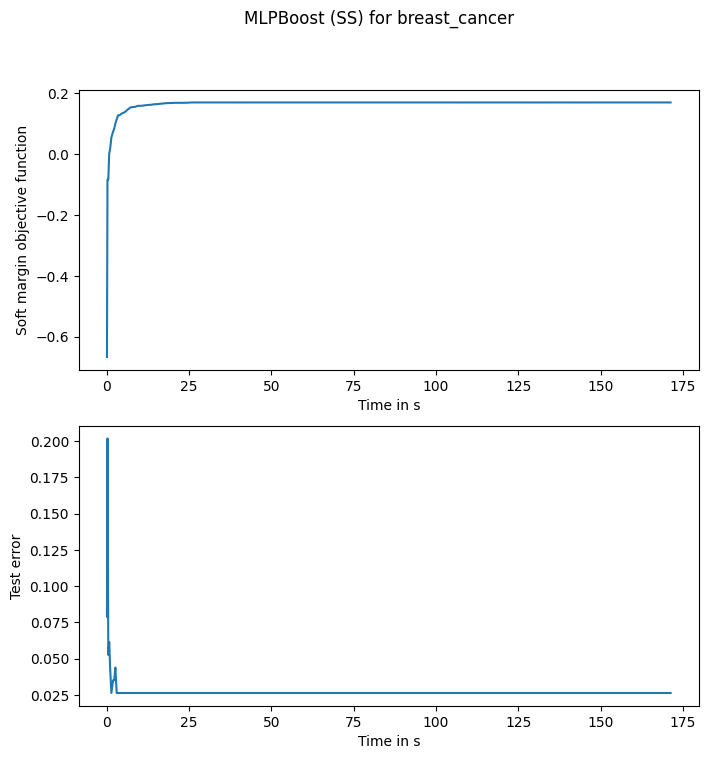

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot((times_SS),obj_f_SS)
axs[1].plot((times_SS),err_test_SS)

axs[0].set_xlabel('Time in s')
axs[0].set_ylabel('Soft margin objective function')

axs[1].set_xlabel('Time in s')
axs[1].set_ylabel('Test error')

fig.suptitle(f'MLPBoost (SS) for {DATASET}')
plt.show()

# save figure
#fig.savefig(path + f'/plots/MLPBoost_SS_{best_v}_{DATASET}.png')

In [32]:
# Average Computing Time over capping parameters

comp_times=[]
for v in CAP_RATIOS:
    print("---------------------------")
    print(f"Starting with v = {v}")   
    MLP_boost = MLPBoost(data_train,data_train.shape[0]*v)

    times_PW, err_test_PW, obj_f_PW, lp_calls_PW = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "Pairwise", fw_only= False)
    comp_times.append(times_PW[-1])
avg_times=np.mean(comp_times) # average comp time for each v

print(f'Average Computation time over the capping params: {avg_times}')

---------------------------
Starting with v = 0.1


 70%|███████   | 70/100 [02:26<01:02,  2.09s/it]


Break loop at: 70
---------------------------
Starting with v = 0.2


100%|██████████| 100/100 [03:50<00:00,  2.31s/it]


---------------------------
Starting with v = 0.3


 20%|██        | 20/100 [00:17<01:11,  1.11it/s]


Break loop at: 20
---------------------------
Starting with v = 0.4


 20%|██        | 20/100 [00:17<01:11,  1.12it/s]


Break loop at: 20
---------------------------
Starting with v = 0.5


 13%|█▎        | 13/100 [00:09<01:06,  1.32it/s]

Break loop at: 13
Average Computation time over the capping params: 78.678125


In [33]:
MLP_boost = MLPBoost(data_train,data_train.shape[0]*best_v)

times_PW, err_test_PW, obj_f_PW, lp_calls_PW = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "Pairwise", fw_only= False)

 70%|███████   | 70/100 [02:12<00:56,  1.90s/it]

Break loop at: 70


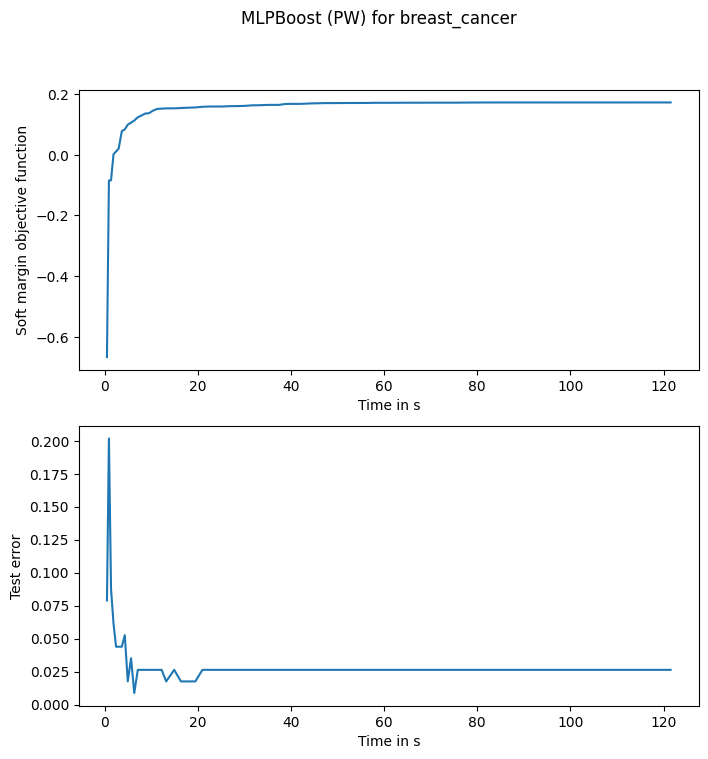

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot((times_PW),obj_f_PW)
axs[1].plot((times_PW),err_test_PW)

axs[0].set_xlabel('Time in s')
axs[0].set_ylabel('Soft margin objective function')

axs[1].set_xlabel('Time in s')
axs[1].set_ylabel('Test error')

fig.suptitle(f'MLPBoost (PW) for {DATASET}')
plt.show()

# save figure
#fig.savefig(path + f'/plots/MLPBoost_PW_{best_v}_{DATASET}.png')

In [36]:
MLP_boost = MLPBoost(data_train,data_train.shape[0]*best_v)

times_PW_only, err_test_PW_only, obj_f_PW_only, lp_calls_PW_only = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "Pairwise", fw_only= True)

100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


In [43]:
err_test_PW_only[-1]

0.02631578947368421

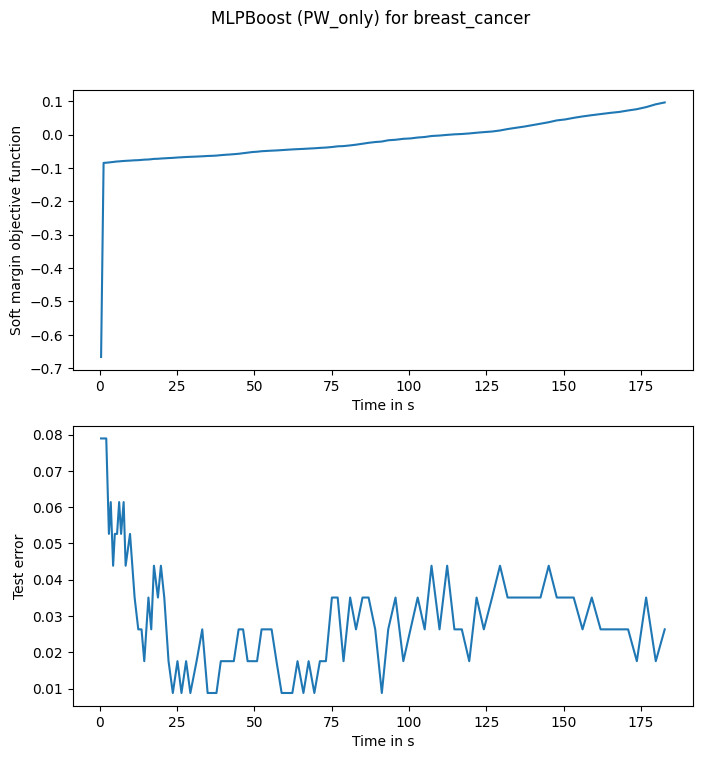

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot((times_PW_only),obj_f_PW_only)
axs[1].plot((times_PW_only),err_test_PW_only)

axs[0].set_xlabel('Time in s')
axs[0].set_ylabel('Soft margin objective function')

axs[1].set_xlabel('Time in s')
axs[1].set_ylabel('Test error')

fig.suptitle(f'MLPBoost (PW_only) for {DATASET} ')
plt.show()

# save figure
#fig.savefig(path + f'/plots/MLPBoost_PW_only_{best_v}_{DATASET}.png')

In [40]:
MLP_boost = MLPBoost(data_train,data_train.shape[0]*best_v)

times_SS_only, err_test_SS_only, obj_f_SS_only, lp_calls_SS_only = MLP_boost.run(data_train,data_train['y'],data_test, fw_strategy= "ShortStep", fw_only= True)

100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


In [42]:
err_test_SS_only[-1]

0.07894736842105263

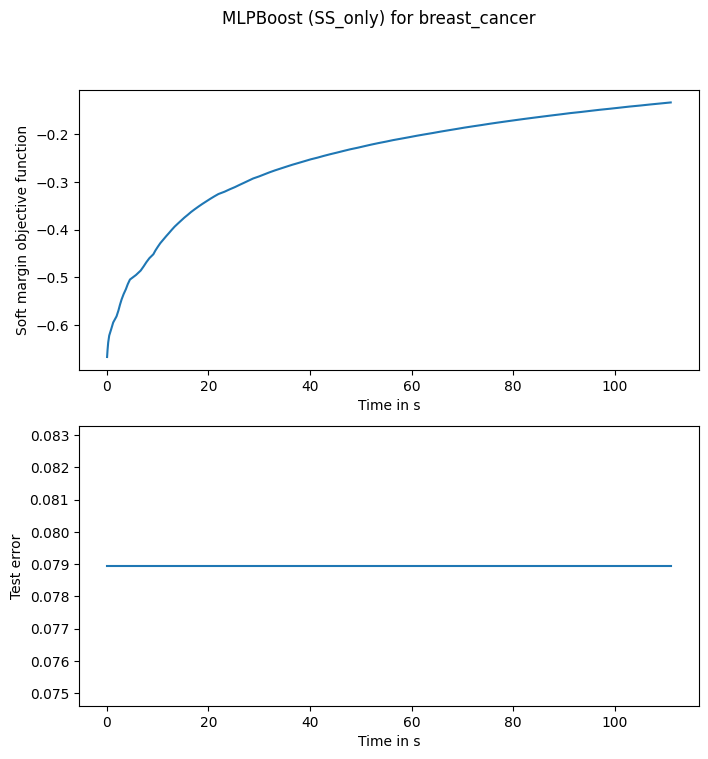

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot((times_SS_only),obj_f_SS_only)
axs[1].plot((times_SS_only),err_test_SS_only)

axs[0].set_xlabel('Time in s')
axs[0].set_ylabel('Soft margin objective function')

axs[1].set_xlabel('Time in s')
axs[1].set_ylabel('Test error')

fig.suptitle(f'MLPBoost (SS_only) for {DATASET}')
plt.show()

# save figure
#fig.savefig(path + f'/plots/MLPBoost_SS_only_{best_v}_{DATASET}.png')

# Compare all Models

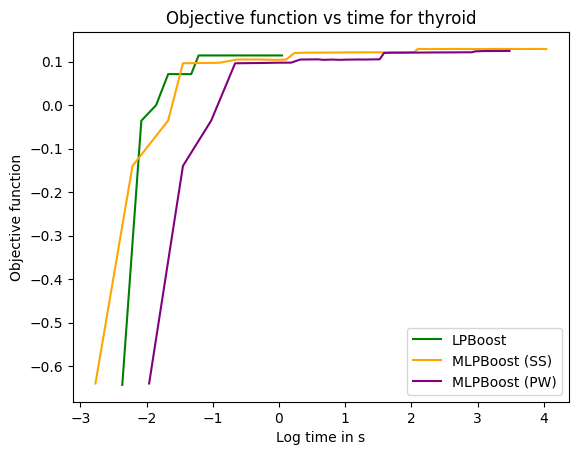

In [25]:
# Plot the objective function vs Log time for all the algorithms
plt.plot(np.log(times_lp), objective_lp, c="green", label="LPBoost")
plt.plot(np.log(times_SS), obj_f_SS, c="orange", label ="MLPBoost (SS)")
plt.plot(np.log(times_PW), obj_f_PW, c="purple", label = "MLPBoost (PW)")
plt.legend(loc="best")
plt.title(f'Objective function vs time for {DATASET}')
plt.xlabel("Log time in s")
plt.ylabel("Objective function")


# save figure
#plt.savefig(path + f'/plots/Objective_function_{best_v}_{DATASET}.png')

plt.show()

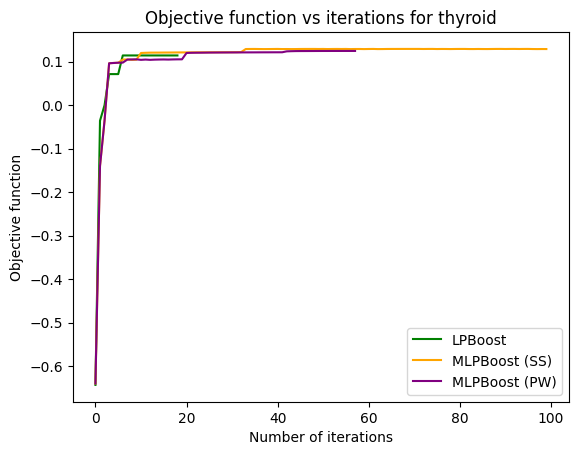

In [26]:
plt.plot(range(len(objective_lp)), objective_lp, c="green", label="LPBoost")
plt.plot(range(len(obj_f_SS)), obj_f_SS, c="orange", label ="MLPBoost (SS)")
plt.plot(range(len(obj_f_PW)), obj_f_PW, c="purple", label = "MLPBoost (PW)")
plt.legend(loc="best")
plt.title(f'Objective function vs iterations for {DATASET}')
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")

# save figure
#plt.savefig(path + f'/plots/Obj_fn_vs_iterations_{best_v}_{DATASET}.png')

plt.show()


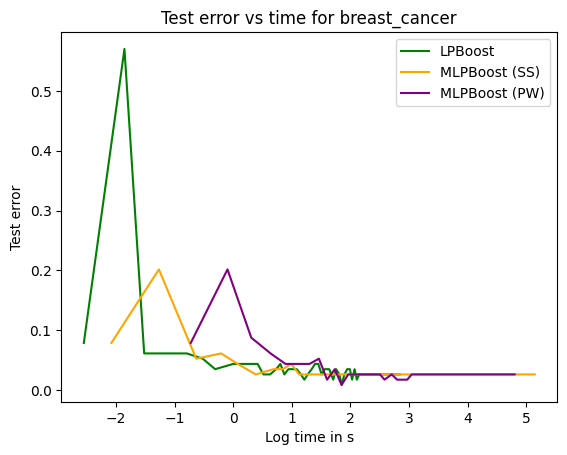

In [46]:
# Plot the test error vs Log time for all the algorithms
plt.plot(np.log(times_lp), test_error_lp, c="green", label="LPBoost")
plt.plot(np.log(times_SS), err_test_SS, c="orange", label ="MLPBoost (SS)")
plt.plot(np.log(times_PW), err_test_PW, c="purple", label = "MLPBoost (PW)")
plt.legend(loc="best")
plt.title(f'Test error vs time for {DATASET}')
plt.xlabel("Log time in s")
plt.ylabel("Test error")

# save figure
plt.savefig(path + f'/plots/Test_error_{best_v}_{DATASET}.png')

plt.show()


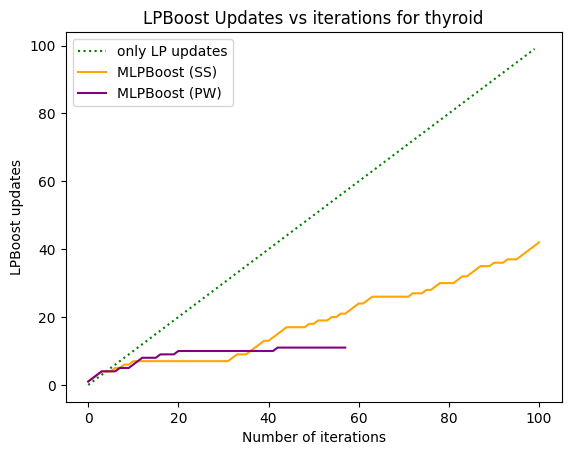

In [28]:
# Plot the number of LPBoost updates vs number of iterations between MLPBoost algorithms
plt.plot(range(100), color="green", linestyle="dotted", label = "only LP updates")
plt.plot(range(len(lp_calls_SS)), lp_calls_SS, color="orange", label ="MLPBoost (SS)")
plt.plot(range(len(lp_calls_PW)),lp_calls_PW, color="purple", label ="MLPBoost (PW)")
plt.legend()
plt.title(f'LPBoost Updates vs iterations for {DATASET}')
plt.xlabel("Number of iterations")
plt.ylabel("LPBoost updates")

# save figure
#plt.savefig(path + f'/plots/LPBoost_updates_{best_v}_{DATASET}.png')

plt.show()

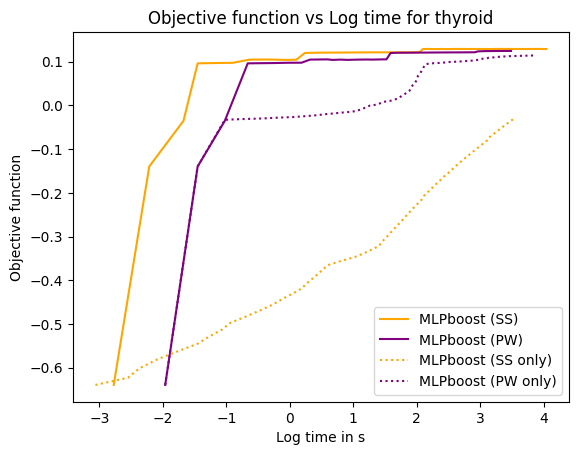

In [29]:
# Plot the objective function vs Log time for all the MLPBoost algorithms
plt.plot(np.log(times_SS), obj_f_SS, c="orange", label ="MLPboost (SS)")
plt.plot(np.log(times_PW), obj_f_PW, c="purple", label = "MLPboost (PW)")
plt.plot(np.log(times_SS_only), obj_f_SS_only, c="orange", linestyle="dotted", label = "MLPboost (SS only)")
plt.plot(np.log(times_PW_only), obj_f_PW_only, c="purple", linestyle="dotted", label = "MLPboost (PW only)")
plt.legend(loc="best")
plt.title(f'Objective function vs Log time for {DATASET}')
plt.xlabel("Log time in s")
plt.ylabel("Objective function")

# save figure
#plt.savefig(path + f'/plots/MLPBoost_all_updates_{best_v}_{DATASET}.png')

plt.show()

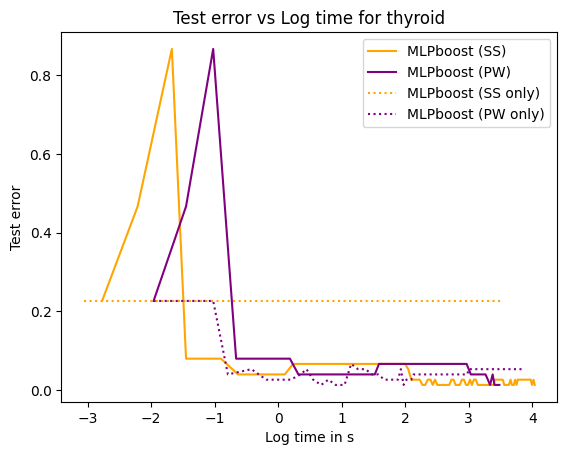

In [30]:
# Plot the test error vs Log time for all the MLPBoost algorithms
plt.plot(np.log(times_SS), err_test_SS, c="orange", label ="MLPboost (SS)")
plt.plot(np.log(times_PW), err_test_PW, c="purple", label = "MLPboost (PW)")
plt.plot(np.log(times_SS_only), err_test_SS_only, c="orange", linestyle="dotted", label = "MLPboost (SS only)")
plt.plot(np.log(times_PW_only), err_test_PW_only, c="purple", linestyle="dotted", label = "MLPboost (PW only)")
plt.legend(loc="best")
plt.title(f'Test error vs Log time for {DATASET}')
plt.xlabel("Log time in s")
plt.ylabel("Test error")

# save figure
#plt.savefig(path + f'/plots/MLPBoost_all_errors_{best_v}_{DATASET}.png')

plt.show()